In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
from typing import Dict
import warnings
warnings.filterwarnings('ignore')
import copy
from tqdm import tqdm
import random
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from stformer import logger
from stformer.tokenizer import GeneVocab
from stformer.tokenizer import tokenize_and_pad_batch_2
from stformer.model import TransformerModel

In [ ]:
class Tokenizer():
    def __init__(self, tokenizer_dir, adata, vocab, pad_value, pad_token):
        self.tokenizer_dir = tokenizer_dir
        self.adata = adata
        self.vocab = vocab
        self.pad_value = pad_value
        self.pad_token = pad_token
        self.load_data()
    
    def load_data(self):
        self.expression_matrix = self.adata.X
        self.niche_ligands_expression = self.adata.obsm['niche_ligands_expression']
        self.niche_composition = self.adata.obsm['niche_composition']
        self.niche_celltypes = self.adata.obsm['niche_celltypes']
        self.cell_types_list = list(self.adata.uns['cell_types_list'])

        gene_list_df = pd.read_csv(f'{self.tokenizer_dir}/OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
        self.gene_list = list(gene_list_df['gene_name'])
        self.gene_ids = np.array(self.vocab(self.gene_list), dtype=int)

        ligand_database = pd.read_csv(self.tokenizer_dir+'ligand_database.csv', header=0, index_col=0)
        ligand_symbol = ligand_database[ligand_database.sum(1)>1].index.values
        self.ligand_symbol = gene_list_df.loc[gene_list_df['gene_name'].isin(ligand_symbol), 'gene_name'].values
        self.ligand_ids = np.array(self.vocab(self.ligand_symbol.tolist())*25, dtype=int)

    def perturb_data(self, pert_receptor=False, pert_ligand=False, pert_receptor_celltype=None, pert_ligand_celltype=None, pert_receptor_genes=None, pert_ligand_genes=None):
        if pert_receptor_celltype is not None:
            pert_receptor_celltype = self.cell_types_list.index(pert_receptor_celltype)+1
        
        if pert_ligand_celltype is not None:
            pert_ligand_celltype = self.cell_types_list.index(pert_ligand_celltype)+1

        pert_expression_matrix = []
        pert_niche_ligands_expression = []
        pert_niche_composition = []
        pert_celltypes = []

        sample_celltypes = self.adata.obs['cell_type'].values

        for i in range(self.adata.shape[0]):
            if pert_receptor_celltype is not None and sample_celltypes[i] != pert_receptor_celltype:
                continue
            
            if pert_ligand_celltype is not None and self.niche_composition[i, np.where(self.niche_celltypes[i].A == pert_ligand_celltype)[1]].sum() == 0:
                continue
            
            pert_expression_matrix_i = self.expression_matrix[i].A
            if pert_expression_matrix_i[0, np.isin(self.gene_list, pert_receptor_genes)].sum() == 0:
                continue

            if pert_ligand_celltype is None:
                pert_ligand_cellindex = np.array(range(25))
            else:
                pert_ligand_cellindex = np.where(self.niche_celltypes[i].A == pert_ligand_celltype)[1]
            
            pert_niche_ligands_expression_i = self.niche_ligands_expression[i].A.reshape(25,986)
            if pert_niche_ligands_expression_i[pert_ligand_cellindex][:, np.isin(self.ligand_symbol, pert_ligand_genes)].sum() == 0:
                continue
            
            if pert_receptor:
                # pert_expression_matrix_i[0, np.isin(self.gene_list, pert_receptor_genes) & (pert_expression_matrix_i[0] > 0)] = pert_expression_matrix_i[0, np.isin(self.gene_list, pert_receptor_genes) & (pert_expression_matrix_i[0] > 0)]/3
                pert_expression_matrix_i[0, np.where((np.isin(self.gene_list, pert_receptor_genes) & (pert_expression_matrix_i[0] > 0))==True)[0][0]] = pert_expression_matrix_i[0, np.where((np.isin(self.gene_list, pert_receptor_genes) & (pert_expression_matrix_i[0] > 0))==True)[0][0]]/3
            if pert_ligand:
                for ci in pert_ligand_cellindex:
                    # pert_niche_ligands_expression_i[ci, np.isin(self.ligand_symbol, pert_ligand_genes) & (pert_niche_ligands_expression_i[ci] > 0)] = pert_niche_ligands_expression_i[ci, np.isin(self.ligand_symbol, pert_ligand_genes) & (pert_niche_ligands_expression_i[ci] > 0)]/3
                    pert_niche_ligands_expression_i[ci, np.where((np.isin(self.ligand_symbol, pert_ligand_genes) & (pert_niche_ligands_expression_i[ci] > 0))==True)[0][0]] = pert_niche_ligands_expression_i[ci, np.where((np.isin(self.ligand_symbol, pert_ligand_genes) & (pert_niche_ligands_expression_i[ci] > 0))==True)[0][0]]/3
            
            pert_expression_matrix.append(pert_expression_matrix_i)
            pert_niche_ligands_expression.append(pert_niche_ligands_expression_i.reshape(1,-1))
            pert_niche_composition.append(self.niche_composition[i].A)
            pert_celltypes.append(sample_celltypes[i])

        self.pert_expression_matrix = np.concatenate(pert_expression_matrix)
        self.pert_niche_ligands_expression = np.concatenate(pert_niche_ligands_expression)
        self.pert_niche_composition = np.concatenate(pert_niche_composition)
        self.pert_celltypes = torch.tensor(pert_celltypes)

    def tokenize_data(self):

        biases = np.zeros([self.pert_niche_composition.shape[0], self.pert_niche_composition.shape[1]*986])
        for k in range(biases.shape[0]):
            biases[k] = np.concatenate([[np.log(p)]*986 for p in self.pert_niche_composition[k]])

        tokenized_data = tokenize_and_pad_batch_2(
            self.pert_expression_matrix,
            self.pert_niche_ligands_expression,
            biases,
            self.gene_ids,
            self.ligand_ids,
            pad_id = self.vocab[self.pad_token],
            pad_value = self.pad_value,
        )
        
        logger.info(
            f"number of samples: {tokenized_data['center_genes'].shape[0]}, "
            f"\n\t feature length of center cell: {tokenized_data['center_genes'].shape[1]}"
            f"\n\t feature length of niche cells: {tokenized_data['niche_genes'].shape[1]}"
        )

        self.tokenized_data = tokenized_data

    def prepare_data(self):
        self.data_pt = {
            "center_gene_ids": self.tokenized_data["center_genes"],
            "input_center_values": self.tokenized_data["center_values"],
            "niche_gene_ids": self.tokenized_data["niche_genes"],
            "input_niche_values": self.tokenized_data["niche_values"],
            "cross_attn_bias": self.tokenized_data["cross_attn_bias"],
            "celltype_labels": self.pert_celltypes,
        }

    def prepare_dataloader(self, batch_size):
        data_loader = DataLoader(
            dataset=SeqDataset(self.data_pt),
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=min(len(os.sched_getaffinity(0)), batch_size // 2),
            pin_memory=True,
        )
        return data_loader

class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["center_gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

In [ ]:
def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    amp = True

    model.eval()
    gene_embeddings_list = []
    selected_center_gene_ids = []

    with torch.no_grad():
        for batch_data in tqdm(loader):
            center_gene_ids = batch_data["center_gene_ids"].to(device)
            if center_gene_ids.size(0)<12:
                continue
            input_center_values = batch_data["input_center_values"].to(device)
            niche_gene_ids = batch_data["niche_gene_ids"].to(device)
            input_niche_values = batch_data["input_niche_values"].to(device)
            cross_attn_bias = batch_data["cross_attn_bias"].to(device)

            encoder_src_key_padding_mask = niche_gene_ids.eq(vocab[pad_token])
            decoder_src_key_padding_mask = center_gene_ids.eq(vocab[pad_token])

            with torch.cuda.amp.autocast(enabled=amp):
                output_dict = model(
                        niche_gene_ids,
                        input_niche_values,
                        encoder_src_key_padding_mask,
                        center_gene_ids,
                        input_center_values,
                        decoder_src_key_padding_mask,
                        cross_attn_bias,
                        output_gene_emb = True,
                    )

                if_selected = torch.isin(center_gene_ids.to('cpu'), torch.tensor(selected_gene_ids))
                gene_embeddings_list.append(output_dict["gene_emb"].to('cpu')[if_selected])
                selected_center_gene_ids.append(center_gene_ids.to('cpu')[if_selected])

    gene_embeddings = torch.cat(gene_embeddings_list)
    selected_center_gene_ids = torch.cat(selected_center_gene_ids)

    return gene_embeddings, selected_center_gene_ids

In [4]:
from scfoundation import load

def initialize_model(model_file):
    pretrainmodel, pretrainconfig = load.load_model_frommmf('scfoundation/models/models.ckpt')

    model = TransformerModel(
            embsize,
            nhead,
            d_hid,
            nlayers,
            do_gcl = True,
            nlayers_gcl = 3,
            n_gcl =2,
            dropout = dropout,
            cell_emb_style = cell_emb_style,
            scfoundation_token_emb1 = copy.deepcopy(pretrainmodel.token_emb),
            scfoundation_token_emb2 = copy.deepcopy(pretrainmodel.token_emb),
            scfoundation_pos_emb1 = copy.deepcopy(pretrainmodel.pos_emb),
            scfoundation_pos_emb2 = copy.deepcopy(pretrainmodel.pos_emb),
        )

    pt_model = torch.load(model_file, map_location='cpu')

    model_dict = model.state_dict()
    pretrained_dict = pt_model.state_dict()
    pretrained_dict = {
                k: v
                for k, v in pretrained_dict.items()
                if 'cls_decoder' not in k and 'gcl_decoder' not in k
                # if k in model_dict and v.shape == model_dict[k].shape
    }
    # for k, v in pretrained_dict.items():
    #     logger.info(f"Loading params {k} with shape {v.shape}")
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())
    for name, para in model.named_parameters():
        para.requires_grad = False
    post_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())
    
    logger.info(f"Total Pre freeze Params {(pre_freeze_param_count )}")
    logger.info(f"Total Post freeze Params {(post_freeze_param_count )}")

    return model

In [ ]:
embsize = 768
d_hid = 3072
nhead = 12
nlayers = 6
dropout = 0.1
cell_emb_style = 'max-pool'

pad_token = "<pad>"
pad_value = 103
tokenizer_dir = '../stformer/tokenizer/'
vocab_file = tokenizer_dir + "scfoundation_gene_vocab.json"
vocab = GeneVocab.from_file(vocab_file)
vocab.append_token(pad_token)
vocab.set_default_index(vocab[pad_token])

batch_size = 20

In [ ]:
model_file = '../pretraining/models/model_4.1M.ckpt'

model = initialize_model(model_file)
model = nn.DataParallel(model, device_ids = [0])
device = torch.device("cuda:0")
model.to(device)

In [ ]:
dataset = 'human_myocardial_infarction'
slide = 'ACH0011'
adata = sc.read_h5ad(f'../datasets/{slide}_niche.h5ad')

tokenizer = Tokenizer(tokenizer_dir, adata, vocab, pad_value, pad_token)

nonzero_niche_genes = set(np.array((tokenizer.ligand_symbol.tolist())*25)[np.nonzero(adata.obsm['niche_ligands_expression'])[1]])
nonzero_center_genes = set(np.array(tokenizer.gene_list)[np.nonzero(adata.X)[1]])

In [ ]:
target_path = 'gene_lists/WNT_direct_targets_vs_housekeeping.csv'
df_target = pd.read_csv(target_path)
wnt_targets = df_target.loc[df_target['Class']=='wnt_direct_target','gene_symbols']
wnt_targets = set(wnt_targets).intersection(nonzero_center_genes)
housekeeping = df_target.loc[df_target['Class']=='housekeeping','gene_symbols']
housekeeping = set(housekeeping).intersection(nonzero_center_genes)

np.random.seed(0)
random_targets = set(np.random.choice(list(nonzero_center_genes-wnt_targets-housekeeping), size=100, replace=False) )

selected_gene_ids = tokenizer.vocab(list(random_targets.union(wnt_targets).union(housekeeping)))

In [ ]:
print("cell types:", tokenizer.cell_types_list)
print("ligand genes:", [g for g in nonzero_niche_genes if 'WNT' in g])
print("receptor genes:", [g for g in nonzero_center_genes if 'FZD' in g])

cell types: ['Adipocyte', 'Cardiomyocyte', 'Cycling cells', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal', 'Pericyte', 'vSMCs']
ligand genes: ['WNT5B', 'WNT2B']
receptor genes: ['FZD6', 'FZD4', 'FZD5']
lowest expression: 4.886720275915682e-05
highest expression: 8.681815663703722


In [ ]:
pert_receptor_celltype = 'Cardiomyocyte'
pert_ligand_celltype = 'Cardiomyocyte'
pert_receptor_genes = ['FZD6', 'FZD4', 'FZD5']
pert_ligand_genes = ['WNT5B', 'WNT2B']

In [ ]:
gene_embeddings_results = {}
selected_center_gene_ids_results = {}

for (pert_receptor, pert_ligand) in [(0,0), (1,0), (0,1), (1,1)]:
    print(f"pert_receptor: {pert_receptor}, pert_ligand: {pert_ligand}")

    tokenizer.perturb_data(pert_receptor, pert_ligand, pert_receptor_celltype, pert_ligand_celltype, pert_receptor_genes, pert_ligand_genes)
    tokenizer.tokenize_data()
    tokenizer.prepare_data()
    data_loader = tokenizer.prepare_dataloader(batch_size)

    gene_embeddings, selected_center_gene_ids = evaluate(model, data_loader)

    gene_embeddings_results[(pert_receptor, pert_ligand)] = gene_embeddings
    selected_center_gene_ids_results[(pert_receptor, pert_ligand)] = selected_center_gene_ids

pert_receptor: 0, pert_ligand: 0
stFormer - INFO - number of samples: 88, 
	 feature length of center cell: 4137
	 feature length of niche cells: 1533


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


pert_receptor: 1, pert_ligand: 0
stFormer - INFO - number of samples: 88, 
	 feature length of center cell: 4137
	 feature length of niche cells: 1533


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


pert_receptor: 0, pert_ligand: 1
stFormer - INFO - number of samples: 88, 
	 feature length of center cell: 4137
	 feature length of niche cells: 1533


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


pert_receptor: 1, pert_ligand: 1
stFormer - INFO - number of samples: 88, 
	 feature length of center cell: 4137
	 feature length of niche cells: 1533


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


In [ ]:
import pickle

pickle.dump(gene_embeddings_results, open(f'figures/insilico_perturbation/gene_embeddings_results.pkl', 'wb'))
pickle.dump(selected_center_gene_ids_results, open(f'figures/insilico_perturbation/selected_center_gene_ids_results.pkl', 'wb'))
pickle.dump(random_targets, open(f'figures/insilico_perturbation/random_targets.pkl', 'wb'))

In [ ]:
def compute_pcc(pert_mode, target_genes):
    pcc = {}
    for gene in target_genes:
        pcc[gene] = []
        ge_origin = gene_embeddings_results[(0,0)][(selected_center_gene_ids_results[(0,0)]==tokenizer.vocab[gene])]
        ge_pert = gene_embeddings_results[pert_mode][(selected_center_gene_ids_results[pert_mode]==tokenizer.vocab[gene])]
        for i in range(ge_origin.shape[0]):
            pcc[gene].append(np.corrcoef(ge_origin[i], ge_pert[i])[0,1])
            # pcc[gene].append(np.linalg.norm(ge_origin[i]-ge_pert[i]))
    return pcc

print("Computing pcc for ligand perturbation")
pcc_wnt_ligand = compute_pcc((0,1), wnt_targets)
pcc_random_ligand = compute_pcc((0,1), random_targets)
pcc_hk_ligand = compute_pcc((0,1), housekeeping)

print("Computing pcc for receptor perturbation")
pcc_wnt_receptor = compute_pcc((1,0), wnt_targets)
pcc_random_receptor = compute_pcc((1,0), random_targets)
pcc_hk_receptor = compute_pcc((1,0), housekeeping)

print("Computing pcc for both ligand and receptor perturbation")
pcc_wnt_both = compute_pcc((1,1), wnt_targets)
pcc_random_both = compute_pcc((1,1), random_targets)
pcc_hk_both = compute_pcc((1,1), housekeeping)

Computing pcc for ligand perturbation
Computing pcc for receptor perturbation
Computing pcc for both ligand and receptor perturbation


In [ ]:
data_wnt_ligand = [k for d in list(pcc_wnt_ligand.values()) for k in d]
data_random_ligand = [k for d in list(pcc_random_ligand.values()) for k in d]
data_hk_ligand = [k for d in list(pcc_hk_ligand.values()) for k in d]

data_wnt_receptor = [k for d in list(pcc_wnt_receptor.values()) for k in d]
data_random_receptor = [k for d in list(pcc_random_receptor.values()) for k in d]
data_hk_receptor = [k for d in list(pcc_hk_receptor.values()) for k in d]

data_wnt_both = [k for d in list(pcc_wnt_both.values()) for k in d]
data_random_both = [k for d in list(pcc_random_both.values()) for k in d]
data_hk_both = [k for d in list(pcc_hk_both.values()) for k in d]

print("ligand perturbation")
print('wnt_targets:', np.median(data_wnt_ligand))
print('random_targets:', np.median(data_random_ligand))
print('housekeeping:', np.median(data_hk_ligand))

print("receptor perturbation")
print('wnt_targets:', np.median(data_wnt_receptor))
print('random_targets:', np.median(data_random_receptor))
print('housekeeping:', np.median(data_hk_receptor))

print("both ligand and receptor perturbation")
print('wnt_targets:', np.median(data_wnt_both))
print('random_targets:', np.median(data_random_both))
print('housekeeping:', np.median(data_hk_both))

ligand perturbation
wnt_targets: 0.9999995271170059
random_targets: 0.9999995745705132
housekeeping: 0.9999996358872718
receptor perturbation
wnt_targets: 0.999999602524391
random_targets: 0.9999996865414894
housekeeping: 0.9999997320929926
both ligand and receptor perturbation
wnt_targets: 0.9999990533233065
random_targets: 0.9999992072819668
housekeeping: 0.9999993690936909


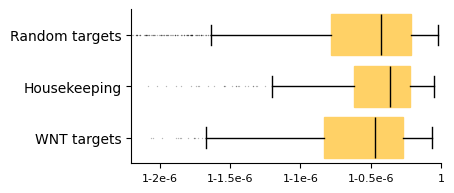

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 2))
data = {'tg': data_wnt_ligand, 'hk': data_hk_ligand, 'tg0': data_random_ligand}
# Plotting the boxplot
f = plt.boxplot(list(data.values()), widths=0.8, patch_artist=True, vert=False, medianprops={'color':'black'}, flierprops={'marker': '+', 'markersize':0.1})

for box in f['boxes']:  # 对箱线图设置颜色
    box.set(color='#ffd166', linewidth=1)
plt.xlim(0.9999978, 1) # 0.9985 0.94

yticks=[1,2,3]
ytick_labels=['WNT targets', 'Housekeeping', 'Random targets']
plt.yticks(yticks, ytick_labels, fontsize=10)


xticks=[0.999998, 0.9999985, 0.999999, 0.9999995, 1]
xtick_labels=['1-2e-6', '1-1.5e-6', '1-1e-6', '1-0.5e-6', '1']
plt.xticks(xticks, xtick_labels, fontsize=8)

ax = plt.gca()  # get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(f'figures/insilico_perturbation/WNT_downreg_ligand_{slide}.pdf', bbox_inches='tight')

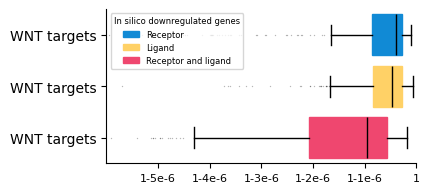

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 2))
data = {'tg': data_wnt_both, 'hk': data_wnt_ligand, 'tg0': data_wnt_receptor}
# Plotting the boxplot
f = plt.boxplot(list(data.values()), widths=0.8, patch_artist=True, vert=False, medianprops={'color':'black'}, flierprops={'marker': '+', 'markersize':0.1})


c_list = ['#ef476f', '#ffd166', '#118AD5']
for box, c in zip(f['boxes'], c_list):  # 对箱线图设置颜色
    box.set(color=c, linewidth=1)
plt.xlim(0.999994, 1) # 0.9985 0.94

yticks=[1,2,3]
ytick_labels=['WNT targets', 'WNT targets', 'WNT targets']
plt.yticks(yticks, ytick_labels, fontsize=10)

xticks=[0.999995, 0.999996, 0.999997, 0.999998, 0.999999, 1]
xtick_labels=['1-5e-6', '1-4e-6', '1-3e-6', '1-2e-6', '1-1e-6', '1']
plt.xticks(xticks, xtick_labels, fontsize=8)

import matplotlib.patches as mpatches
patch1 = mpatches.Patch(color='#118AD5', label='Receptor')
patch2 = mpatches.Patch(color='#ffd166', label='Ligand')
patch3 = mpatches.Patch(color='#ef476f', label='Receptor and Ligand')
plt.legend(title='In silico downregulated genes', title_fontsize=6, handles=[patch1, patch2, patch3], loc='upper left', labels=['Receptor', 'Ligand', 'Receptor and ligand'], fontsize=6)

ax = plt.gca()  # get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(f'figures/insilico_perturbation/WNT_downreg_all_{slide}.pdf', bbox_inches='tight')

In [74]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests


receptor_hk = ranksums(data_hk_receptor, data_random_receptor, alternative='greater')
receptor_tg = ranksums(data_wnt_receptor, data_random_receptor, alternative='less')
ligand_hk = ranksums(data_hk_ligand, data_random_ligand, alternative='greater')
ligand_tg = ranksums(data_wnt_ligand, data_random_ligand, alternative='less')
both_hk = ranksums(data_hk_both, data_random_both, alternative='greater')
both_tg = ranksums(data_wnt_both, data_random_both, alternative='less')
both_ligand = ranksums(data_wnt_both, data_wnt_ligand, alternative='less')
both_receptor = ranksums(data_wnt_both, data_wnt_receptor, alternative='less')

p_values = [receptor_hk.pvalue, receptor_tg.pvalue, ligand_hk.pvalue, ligand_tg.pvalue, both_hk.pvalue, both_tg.pvalue, both_ligand.pvalue, both_receptor.pvalue]
print("p-values:", p_values)

_, p_values_fdr, _, _ = multipletests(p_values, method='fdr_bh')
print("FDR-corrected p-values:", p_values_fdr)

p-values: [7.135301582187237e-07, 3.5121465374540722e-12, 0.0016584700601789786, 0.007286855451578857, 1.6071325296015287e-06, 5.997952666051098e-09, 3.4494041430195795e-31, 3.964248252828887e-24]
FDR-corrected p-values: [1.14164825e-06 9.36572410e-12 1.89539435e-03 7.28685545e-03
 2.14284337e-06 1.19959053e-08 2.75952331e-30 1.58569930e-23]
